In [1]:
from itertools import chain
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
import lightning.pytorch as pl
from convert_pilimage_to_onehot import convert_pilimage_to_onehot
from my_lightning_module import MyLightningModule
from dataset1 import Dataset1
from train import Train
import arc_json_model as ajm
from visualize import ajm_image_show
import export_task_to_image as etti
from pil_image_from_pixels import pil_image_from_pixels_with_red_palette
from simple_image import image_new, set_pixel, draw_rect, draw_box

ajm.Image.show = ajm_image_show

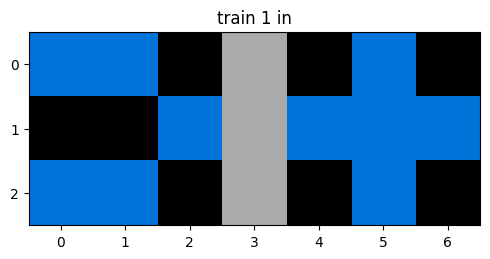

In [2]:
#filename = 'testdata/1c0d0a4b.json'
#filename = 'testdata/c3202e5a.json'
#filename = 'testdata/0b148d64.json'
#filename = 'testdata/95a58926.json'
filename = 'testdata/a59b95c0.json'
filename = 'testdata/0520fde7.json'
#filename = 'testdata/e98196ab.json'
#filename = 'testdata/23581191.json'
#filename = 'testdata/281123b4.json'
#filename = 'testdata/3428a4f5.json'
#filename = 'testdata/48131b3c.json'
#filename = 'testdata/af902bf9.json'
#filename = 'testdata/cf98881b.json'
#filename = 'testdata/f2829549.json'
#filename = 'testdata/be94b721.json'
#filename = 'testdata/6773b310.json'
task = ajm.Task.load(filename)
image = task.pairs[1].input
image.show()

In [3]:
#checkpoint = "./lightning_logs/version_1/checkpoints/epoch=0-step=100.ckpt"
#checkpoint = "./lightning_logs/version_12/checkpoints/epoch=0-step=64.ckpt"
#checkpoint = "./lightning_logs/version_1/checkpoints/epoch=75-step=4864.ckpt"
#checkpoint = "./lightning_logs/version_2/checkpoints/epoch=99-step=6400.ckpt"
checkpoint = "./lightning_logs/version_4/checkpoints/epoch=99-step=6400.ckpt"
model_outer = MyLightningModule.load_from_checkpoint(checkpoint)
model = model_outer.model
model.eval() ;

output size:  3 3


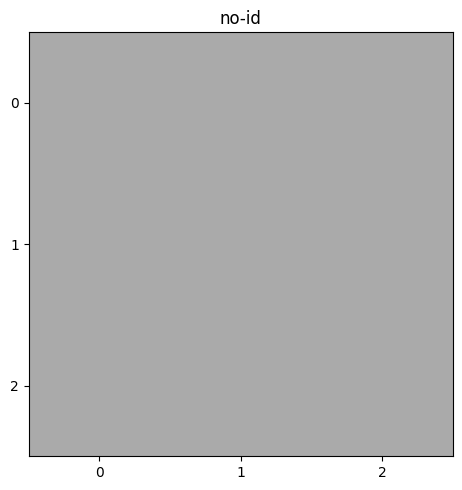

In [4]:
transform_image = Dataset1.create_transform()
exporter = etti.ExportTaskToImage(task)
pair = task.pairs[0]
output_image_shape = pair.output.pixels.shape
width = output_image_shape[1]
height = output_image_shape[0]
print("output size: ", width, height)
predicted_pixels = image_new(width, height, 255)

with torch.no_grad():
    for y in range(height):
        for x in range(width):
            pixels = exporter.image_with_mark(0, x, y)
            pil_image = pil_image_from_pixels_with_red_palette(pixels)
    
            img_transformed1 = transform_image(pil_image)
            img_transformed2 = convert_pilimage_to_onehot(img_transformed1)
            img_transformed3 = img_transformed2.transpose(2, 0, 1)
            tensor = torch.from_numpy(img_transformed3.astype(np.float32))
            
            #tensor = test_transforms(pil_image)
            tensor = tensor[None, :]
            #if x == 0 and y == 0:
                #pil_image.show()
            #if x == 2 and y == 2:
                #pil_image.show()
            #if x == 3 and y == 3:
                #pil_image.show()
                #print(tensor.shape)
    
            data = tensor.to(model_outer.device)
            output = model(data)
            #print(output)
            output_tensor = output.cpu().detach()
            #print(output_tensor)
            output_value = output_tensor.argmax(dim=1)
            #output_value = output_tensor.argmax(dim=None)
            #print(output_value)
            #result_pixels
            set_pixel(predicted_pixels, x, y, output_value)

predicted_image = ajm.Image(predicted_pixels, 'no-id')
predicted_image.show()